## Feedback
Good job! Task2.a. (1,5/2) Your query is well-structured and calculates the mutation frequency effectively. However, it does not correctly identify the GGG > AAC mutation, as it checks individual positions independently without ensuring all three positions satisfy the conditions. Adding a HAVING COUNT(DISTINCT v.pos) = 3 condition or separate joins for each position would improve accuracy.

---
---

# Homework 9. - Biology databases
## Balázs Menkó (O67UT7)
---

## 1. Exploring Bird Influenza (H5N1) Publications in PubMed After 2023

The goal of this task is to use Entrez tools to search for bird influenza-related (__H5N1__) publications __after 2023__ in the __PubMed__ database and retrieve detailed information about the first three records. You can use two fields to refine your search and extract metadata about the articles.


### 1.a. Define the Search Query and Use Entrez.esearch (2 points)

In [ ]:
# Import modules, set email
from Bio import Entrez, SeqIO, Seq

# Specify your email address
Entrez.email = "menkobalazs@student.elte.hu"

# Define the search term (use field like 'Words in title of publication' and 'Date of publication')
search_term = '(H5N1[TI]) AND ("2024/01/01"[DP] : "3000"[DP])'

# Search for publications
with Entrez.esearch(db="pubmed", term=search_term, retmax=3) as handle:
    search_results = Entrez.read(handle)

# Display the number of results and IDs
num_results = search_results["Count"]
id_list = search_results["IdList"]

print(f"Number of results: {num_results}")
print(f"IDs of the first few results: {id_list}")

Number of results: 236
IDs of the first few results: ['39607051', '39599818', '39599570']


### 1.b. Retrieve Summaries Using Entrez.esummary (2 points)

In [2]:
# Retrieve summaries for the first few records
with Entrez.esummary(db="pubmed", id=",".join(id_list)) as handle:
    summaries = Entrez.read(handle)

# Print summary details
for i, record in enumerate(summaries, 1):  
    # Extract details
    title = record.get("Title", "N/A")
    journal = record.get("Source", "N/A")
    pub_date = record.get("PubDate", "N/A")
    authors = record.get("AuthorList", [])
    # Print details
    print(f"--- Record {i} ---")
    print(f"  Title: {title}")
    print(f"  Journal: {journal}")
    print(f"  Publication Date: {pub_date}")
    print(f"  Authors: {', '.join(authors) if authors else 'N/A'}")
    print()

--- Record 1 ---
  Title: Incidence of highly pathogenic avian influenza H5N1 in pinnipeds in Uruguay.
  Journal: Dis Aquat Organ
  Publication Date: 2024 Nov 28
  Authors: Szteren D, Franco-Trecu V

--- Record 2 ---
  Title: Emerging Threats of Highly Pathogenic Avian Influenza A (H5N1) in US Dairy Cattle: Understanding Cross-Species Transmission Dynamics in Mammalian Hosts.
  Journal: Viruses
  Publication Date: 2024 Oct 30
  Authors: Sreenivasan CC, Li F, Wang D

--- Record 3 ---
  Title: Highly Pathogenic H5N1 Influenza A Virus (IAV) in Blue-Winged Teal in the Mississippi Flyway Is Following the Historic Seasonal Pattern of Low-Pathogenicity IAV in Ducks.
  Journal: Pathogens
  Publication Date: 2024 Nov 19
  Authors: Stallknecht DE, Carter DL, Sullivan-Brügger L, Link P, Ferraro E, McCarty C, Davis B, Knutsen L, Graham J, Poulson RL



----

## 2. Advanced SQL Queries on Mutation Data: Temporal and Variant Analysis

In this task, you will further explore the task2 database that we worked with during the practical session.

In [3]:
import os
import sqlite3
import pandas as pd
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt

def run_query(query, database="vcf_sarscov2_2024.db"):
    if not os.path.exists(database):
        raise FileNotFoundError(f"The file '{database}' does not exist.")
    else:
        conn = sqlite3.connect(database)
        df = sqlio.read_sql_query(query, conn)
        conn.close()
        return df

In [4]:
run_query("""
    SELECT name as table_names
    FROM sqlite_master
    WHERE type = 'table'
""")

,table_names
0,meta
1,lineage
2,country
3,vcf


### 2.a. Temporal Analysis of Trinucleotide Mutation Frequency (2 points) 

Create an SQL query to conduct a temporal analysis of the frequency of trinucleotide mutations across samples. Specifically, calculate the ratio of samples containing the mutation (GGG > AAC at positions 28881–28883) to the total number of samples collected on each date. Display the results as a line plot.

**Suggestions**:

- Use the 'meta' and 'vcf' tables to extract pertinent information. Integrate a temporary table to calculate the total number of samples collected on each date. 
- Filter samples based on the specified trinucleotide mutation (e.g. ref:G, pos:28881, alt:A) in a temporary table, ensuring mutation dominance in that allele (allele frequency greater than 50%).

In [5]:
run_query("""
    SELECT name as table_names
    FROM sqlite_master
    WHERE type = 'table'
""")

,table_names
0,meta
1,lineage
2,country
3,vcf


In [6]:
run_query("""
    SELECT *
    FROM meta
""").head(3)

,runid,collection_date,country_id,host,instrument_platform
0,96,2021-10-12,211.0,Homo sapiens,ILLUMINA
1,2609,2021-11-13,211.0,Homo sapiens,ILLUMINA
2,4109,2021-11-14,211.0,Homo sapiens,ILLUMINA


In [7]:
run_query("""
    SELECT *
    FROM lineage
""").head(3)

,runid,variant_id
0,96,Delta
1,2609,Delta
2,4109,Delta


In [8]:
run_query("""
    SELECT *
    FROM country
""").head(3)

,id,country_name
0,211,United Kingdom
1,211,United Kingdom
2,211,United Kingdom


In [9]:
run_query("""
    SELECT *
    FROM vcf
""").head(3)

,runid,pos,ref,alt,af,dp
0,6240362,17124,T,C,0.667488,406
1,1333047,14408,C,T,0.995419,2401
2,1669679,7851,C,T,0.999852,6763


In [10]:
df = run_query("""
    WITH 
    -- Count total samples per collection date
    total_samples AS (
        SELECT 
            m.collection_date,
            COUNT(DISTINCT m.runid) AS total_samples
        FROM meta m
        GROUP BY m.collection_date
    ),
    
    -- Identify samples with the trinucleotide mutation GGG > AAC
    mutation_samples AS (
        SELECT 
            m.collection_date,
            v.runid
        FROM meta m
        INNER JOIN vcf v ON m.runid = v.runid
        WHERE 
            (v.pos = 28881 AND v.ref = 'G' AND v.alt = 'A' AND v.af > 0.5)
            OR (v.pos = 28882 AND v.ref = 'G' AND v.alt = 'A' AND v.af > 0.5)
            OR (v.pos = 28883 AND v.ref = 'G' AND v.alt = 'C' AND v.af > 0.5)
        GROUP BY m.collection_date, v.runid
    ),
    
    -- Aggregate mutation counts by date
    mutation_counts AS (
        SELECT 
            ms.collection_date,
            COUNT(DISTINCT ms.runid) AS mutation_samples
        FROM mutation_samples ms
        GROUP BY ms.collection_date
    )
    
    -- Calculate the frequency of mutations per date
    SELECT 
        ts.collection_date,
        COALESCE(mc.mutation_samples, 0) * 1.0 / ts.total_samples AS mutation_frequency
    FROM total_samples ts
    LEFT JOIN mutation_counts mc ON ts.collection_date = mc.collection_date
    ORDER BY ts.collection_date;
""")

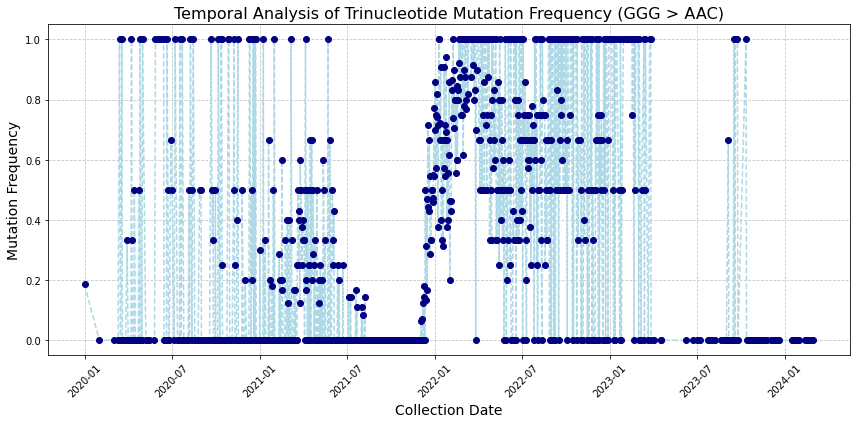

In [11]:
df['collection_date'] = pd.to_datetime(df['collection_date'])

plt.figure(figsize=(12, 6))
plt.plot(df['collection_date'], df['mutation_frequency'], '--', color='lightblue')
plt.plot(df['collection_date'], df['mutation_frequency'], 'o', color='navy')
plt.title('Temporal Analysis of Trinucleotide Mutation Frequency (GGG > AAC)', fontsize=16)
plt.xlabel('Collection Date', fontsize=14)
plt.ylabel('Mutation Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.b. Deletion and Insertion Ratio in Variants (2 points)

Create an SQL query to analyze the ratio of deletions to insertions within each variant. Calculate this ratio as the percentage of deletions and insertions among all mutations within a variant. Which variants have the highest ratio of insertion to deletion? Create a plot.

**Suggestions:**
- Use information from the 'vcf' and 'lineage' tables.
- Distinguish between deletions and insertions based on the length of the reference and altered bases in the 'vcf' table. Define deletions as cases where the length of the reference allele is greater than the length of the alternative allele. Define insertions as cases where the length of the reference allele is smaller than the length of the alternative allele.
- Express the ratio as a percentage for clarity.

In [12]:
df2 = run_query("""
    WITH 
    -- Classify mutations as deletions or insertions
    classified_mutations AS (
        SELECT 
            l.variant_id,
            v.runid,
            CASE 
                WHEN LENGTH(v.ref) > LENGTH(v.alt) THEN 'deletion'
                WHEN LENGTH(v.ref) < LENGTH(v.alt) THEN 'insertion'
                ELSE 'other'
            END AS mutation_type
        FROM vcf v
        INNER JOIN lineage l ON v.runid = l.runid
    ),
    
    -- Aggregate counts of deletions and insertions by variant
    mutation_counts AS (
        SELECT 
            cm.variant_id,
            SUM(CASE WHEN cm.mutation_type = 'deletion' THEN 1 ELSE 0 END) AS deletions,
            SUM(CASE WHEN cm.mutation_type = 'insertion' THEN 1 ELSE 0 END) AS insertions,
            COUNT(*) AS total_mutations
        FROM classified_mutations cm
        GROUP BY cm.variant_id
    ),
    
    -- Calculate percentages and ratios
    ratios AS (
        SELECT 
            mc.variant_id,
            mc.deletions * 100.0 / mc.total_mutations AS deletion_percentage,
            mc.insertions * 100.0 / mc.total_mutations AS insertion_percentage,
            mc.insertions * 1.0 / NULLIF(mc.deletions, 0) AS insertion_to_deletion_ratio
        FROM mutation_counts mc
    )
    
    -- Select final results sorted by the insertion-to-deletion ratio
    SELECT 
        r.variant_id,
        r.deletion_percentage,
        r.insertion_percentage,
        r.insertion_to_deletion_ratio
    FROM ratios r
    ORDER BY r.insertion_to_deletion_ratio DESC;
""")

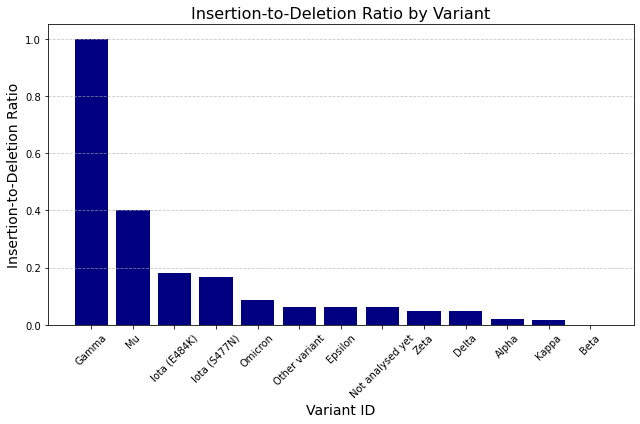

In [13]:
plt.figure(figsize=(9, 6))
plt.bar(df2['variant_id'], df2['insertion_to_deletion_ratio'], color='navy')
plt.title('Insertion-to-Deletion Ratio by Variant', fontsize=16)
plt.xlabel('Variant ID', fontsize=14)
plt.ylabel('Insertion-to-Deletion Ratio', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()